<a href="https://colab.research.google.com/github/yaxuanhh/stats507Winter2025/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, default_data_collator
from datasets import Dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load data
df = pd.read_csv("hf://datasets/AhmedSSoliman/sentiment-analysis-for-mental-health-Combined-Data/sentiment-analysis-for-mental-health-Combined Data.csv")
print(df.status.unique())
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])

texts = df['statement'].tolist()
labels = df['status'].tolist()

new_labels = []
labels_to_id = {}

for label in labels:
    if label not in labels_to_id:
        labels_to_id[label] = len(labels_to_id)
    new_labels.append(labels_to_id[label])
labels = new_labels


X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]


train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)


train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': y_train})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': y_test})


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)


model.to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return { 'accuracy': accuracy_score(labels, preds) }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics
)


trainer.train()


model.save_pretrained('./sentiment_analysis_model')
tokenizer.save_pretrained('./sentiment_analysis_model')


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: huang-yaxuan99 (huang-yaxuan99-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.451100,0.473577,0.806956
2,0.393900,0.456946,0.826657
3,0.176800,0.524920,0.826468
4,0.182800,0.671799,0.827316
5,0.064300,0.858164,0.826374


('./sentiment_analysis_model/tokenizer_config.json',
 './sentiment_analysis_model/special_tokens_map.json',
 './sentiment_analysis_model/vocab.txt',
 './sentiment_analysis_model/added_tokens.json')

In [5]:
predictions_output = trainer.predict(test_dataset)

logits = predictions_output.predictions
y_true = predictions_output.label_ids

y_pred = np.argmax(logits, axis=-1)

class_names = [
    'Anxiety','Normal','Depression','Suicidal','Stress','Bipolar','Personality disorder'
]

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

                      precision    recall  f1-score   support

             Anxiety     0.8723    0.8947    0.8834       779
              Normal     0.9660    0.9555    0.9607      3327
          Depression     0.7831    0.7697    0.7763      3100
            Suicidal     0.6955    0.7131    0.7042      2018
              Stress     0.7648    0.6948    0.7281       557
             Bipolar     0.8730    0.8293    0.8506       580
Personality disorder     0.5809    0.8105    0.6768       248

            accuracy                         0.8267     10609
           macro avg     0.7908    0.8097    0.7972     10609
        weighted avg     0.8296    0.8267    0.8275     10609



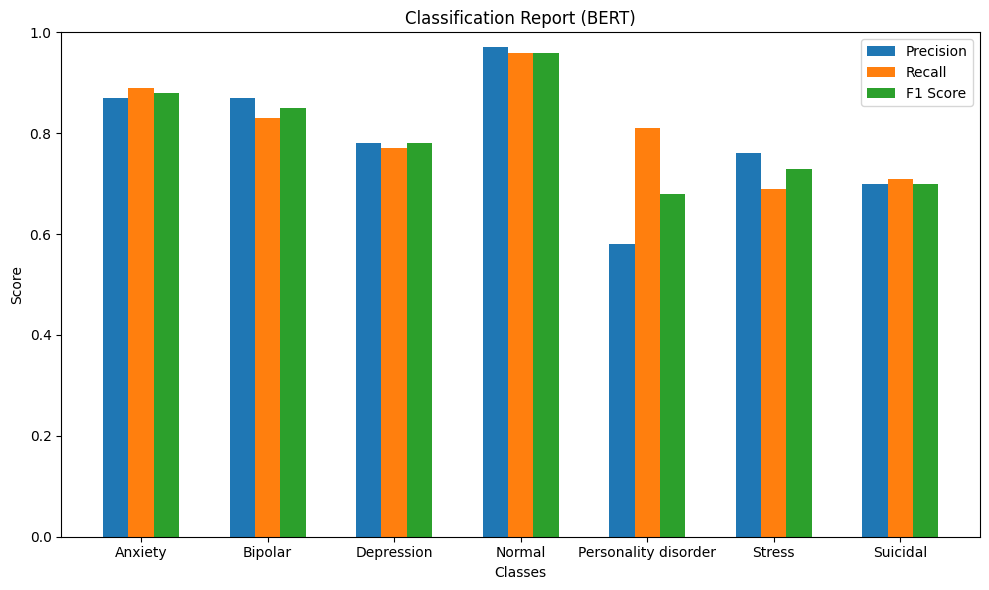

In [7]:
classes = ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']
precision = [0.87, 0.87, 0.78, 0.97, 0.58, 0.76, 0.70]
recall    = [0.89, 0.83, 0.77, 0.96, 0.81, 0.69, 0.71]
f1_score  = [0.88, 0.85, 0.78, 0.96, 0.68, 0.73, 0.70]

x = np.arange(len(classes))
width = 0.2

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1 Score')


plt.ylabel('Score')
plt.xlabel('Classes')
plt.title('Classification Report (BERT)')
plt.xticks(x, classes)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()